- By: Alex Kwon
- Reference: Online Portfolio Selection: Principles and Algorithms

# Online Portfolio Selection

### Introduction

Online Portfolio Selection sequentially allocates capital among a set of assets aiming to maximize the final return of investment in a long run. OLPS plays a crucial role in a wide range of financial investment applications, such as automated wealth management, hedge fund management, and quantitative trading.

This notebook explores the OLPS module implemented in mlfinlab.

In [26]:
import numpy as np
import pandas as pd
import os
# import from mlfinlab
import mlfinlab
from mlfinlab.online_portfolio_selection import *

%matplotlib inline
np.random.seed(42)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Importing Data

In [27]:
stock_prices = pd.read_csv('../tests/test_data/stock_prices.csv', parse_dates=True, index_col='Date')
stock_prices = stock_prices.dropna(axis=1)

In [28]:
stock_prices.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.27333,35.39000,106.64000,52.92000,78.22000,87.63000,37.94000,47.76000,41.30000,79.50000,...,42.09000,51.17333,55.98333,74.53000,67.31000,144.92999,94.38000,77.36000,101.40000,130.63000
2008-01-03,49.71667,35.29000,107.00000,53.12000,78.35000,87.81000,37.92000,48.06000,42.05000,80.44000,...,42.03000,51.29333,55.60000,74.80000,67.50000,144.86000,94.25000,77.46000,101.52000,130.74001
2008-01-04,48.22333,34.60000,106.97000,51.76000,76.57000,88.04000,36.99000,46.92000,40.78000,77.50000,...,42.35000,49.85000,54.53667,72.98000,65.77000,141.31000,94.27000,77.55000,101.65000,128.17000
2008-01-07,48.57667,34.63000,106.95000,51.44000,76.65000,88.20000,37.26000,47.06000,40.22000,77.20000,...,43.23000,50.41667,56.11667,72.95000,65.65000,141.19000,94.68000,77.57000,101.72000,128.06000
2008-01-08,48.20000,34.39000,107.03000,51.32000,76.22000,88.39000,36.97000,46.40000,39.60000,75.85000,...,43.24000,49.56667,55.32667,72.40000,65.36000,138.91000,94.57000,77.65000,101.74000,125.85000


## Benchmarks

We will first look at the benchmark strategies.

### Buy and Hold

Invests with initial portfolio and holds until the end

We will set an arbitray initial portfolio weights to be 0.25 for the first 4 assets, and then we will allocate those inital weights according to the Buy and Hold strategy. The price data will be resampled by month.

In [29]:
init_portfolio = np.zeros(stock_prices.shape[1])
init_portfolio[[0,1,2,3]] = 0.25
bah = BuyAndHold()
bah.allocate(stock_prices, weights=init_portfolio, resample_by='M')

all_weights returns the history of weights allocated for each time period, in this case month.

In [30]:
bah.all_weights.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-02-29,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-03-31,0.25454,0.24780,0.25182,0.24584,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-04-30,0.24746,0.25458,0.25282,0.24514,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-05-31,0.25877,0.25299,0.23608,0.25216,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Notice how the weights actually deviate from the original 0.25 allocated in the beginning. This is due to the fact that the underlying asset changed its price and therefore changes our weight allocation to each asset.
Now, we will see the portfolio returns over time.

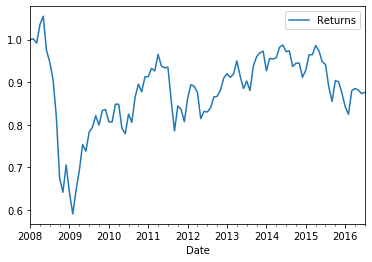

In [31]:
bah.portfolio_return.plot()

We end up with less portfolio value than we started with because the asset prices mostly decreased.

### Best Stock

Invests all capital in the best performing stock in hindsight

In [32]:
best_stock = BestStock()
best_stock.allocate(stock_prices, resample_by='M')

In [33]:
print(best_stock.all_weights.iloc[[0]])
print(best_stock.all_weights.iloc[[-1]])

               EEM     EWG     TIP     EWJ     EFA     IEF     EWQ     EWU  \
Date                                                                         
2008-01-31 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000   

               XLB     XLE  ...     XLU     EPP     FXI     VGK     VPL  \
Date                        ...                                           
2008-01-31 0.00000 0.00000  ... 0.00000 0.00000 0.00000 0.00000 0.00000   

               SPY     TLT     BND     CSJ     DIA  
Date                                                
2008-01-31 0.00000 1.00000 0.00000 0.00000 0.00000  

[1 rows x 23 columns]
               EEM     EWG     TIP     EWJ     EFA     IEF     EWQ     EWU  \
Date                                                                         
2016-07-31 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000   

               XLB     XLE  ...     XLU     EPP     FXI     VGK     VPL  \
Date                        ...                

As seen with the previous two lines, the first and last weights are identical with the weights all 0's except for TLT. This happens because TLT is the best performing stock during this period.

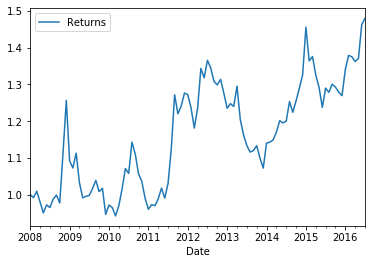

In [34]:
best_stock.portfolio_return.plot()


### Constant Rebalanced Portfolio

Rebalances to a given portfolio every period

In [35]:
crp = ConstantRebalancedPortfolio()
crp.allocate(stock_prices, weights=init_portfolio, resample_by='M')

If we print out all the weights below, we can notice that the weights stay constant for every time period. We are consistently rebalancing our portfolio to track the initial weights.

In [36]:
crp.all_weights

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-02-29,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-03-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-04-30,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-05-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-04-30,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-05-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


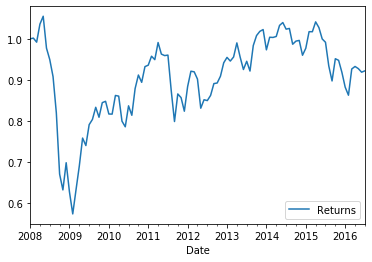

In [37]:
crp.portfolio_return.plot()

### Best Constant Rebalanced Portfolio

This is the best ConstantRebalancedPortfolio strategy in hindsight. We calculate the best performing fixed portfolio weight.

In [38]:
bcrp = BestConstantRebalancedPortfolio()
bcrp.allocate(stock_prices, resample_by='M')

In [39]:
bcrp.all_weights.iloc[0]

EEM   0.00000
EWG   0.00000
TIP   0.00000
EWJ   0.00000
EFA   0.00000
IEF   0.00000
EWQ   0.00000
EWU   0.00000
XLB   0.00000
XLE   0.00000
XLF   0.00000
LQD   0.00000
XLK   0.89725
XLU   0.00000
EPP   0.00000
FXI   0.00000
VGK   0.00000
VPL   0.00000
SPY   0.00000
TLT   0.10275
BND   0.00000
CSJ   0.00000
DIA   0.00000
Name: 2008-01-31 00:00:00, dtype: float64

In [40]:
bcrp.all_weights.iloc[-1]

EEM   0.00000
EWG   0.00000
TIP   0.00000
EWJ   0.00000
EFA   0.00000
IEF   0.00000
EWQ   0.00000
EWU   0.00000
XLB   0.00000
XLE   0.00000
XLF   0.00000
LQD   0.00000
XLK   0.89725
XLU   0.00000
EPP   0.00000
FXI   0.00000
VGK   0.00000
VPL   0.00000
SPY   0.00000
TLT   0.10275
BND   0.00000
CSJ   0.00000
DIA   0.00000
Name: 2016-07-31 00:00:00, dtype: float64

From the above two portfolio weights for the first and last period, we see that the weights are identical with 0.89725 allocated to XLK and 0.10275 to TLT.

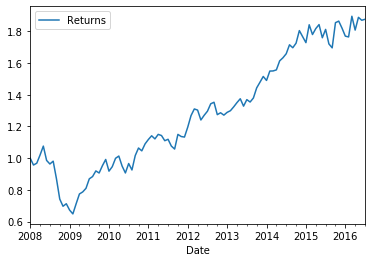

In [41]:
bcrp.portfolio_return.plot()

From the plot, we can see that the BestConstantRebalancedPortfolio produces the highest portfolio returns so far. This happens because we are calculating the weights with the given market sequence. We cannot effectively predict the future, so this will be impossible to replicate with a given past information.

## Momentum

We will now move on to momentum, which follows the winners in the past.

### Exponential Gradient

Tracks the best performing stock but also adheres to the previous portfolio value by an additional regularization term
There are three update methods that we will be using: multiplicative update, gradient projection, and expectation maximization

In [42]:
multiplicative_update = EG(eta=0, update_rule='MU')
multiplicative_update.allocate(stock_prices, weights=init_portfolio, resample_by='M')
gradient_projection = EG(eta=.5, update_rule='GP')
gradient_projection.allocate(stock_prices, weights=init_portfolio, resample_by='M')
expectation_maximization = EG(eta=10, update_rule='EM')
expectation_maximization.allocate(stock_prices, weights=init_portfolio, resample_by='M')

If the learning rate, eta, is 0, the algorithm does not change its value, and therefore we see that the first and last weights are the same

In [43]:
multiplicative_update.all_weights.iloc[[0,-1]]

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-07-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


For a higher eta, we can see that the weights diverge to track the best performing stock in the previous period.

In [44]:
expectation_maximization.all_weights.iloc[[0,1,-2,-1]]

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-02-29,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-06-30,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-07-31,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


For a more reasonable value of eta, we see that the weights still follow the original portfolio yet follow the best stocks in the past periods.


In [45]:
gradient_projection.all_weights.iloc[[0,1,-2,-1]]

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-02-29,0.25000,0.25000,0.25000,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-06-30,0.06863,0.11560,0.11963,0.10868,0.00000,0.03175,0.00000,0.00000,0.06192,0.00443,...,0.04706,0.00000,0.00000,0.00000,0.00000,0.10757,0.08028,0.00000,0.00000,0.08300
2016-07-31,0.07563,0.09234,0.12026,0.09794,0.00000,0.03849,0.00000,0.00000,0.05648,0.01026,...,0.06277,0.00000,0.00000,0.00000,0.00000,0.10271,0.09427,0.00000,0.00000,0.08171


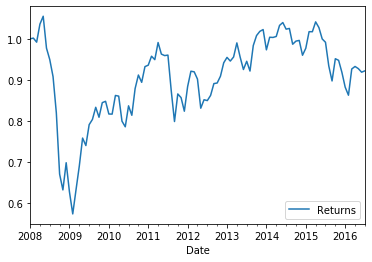

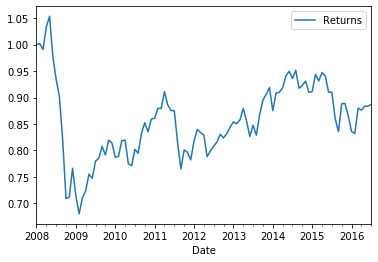

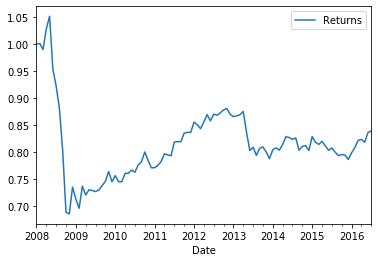

In [46]:
multiplicative_update.portfolio_return.plot()
gradient_projection.portfolio_return.plot()
expectation_maximization.portfolio_return.plot()

### Follow the Leader

Tracks the BestConstantRebalancedPortfolio strategy over known periods. This is different from the original BestConstantRebalancedPortfolio strategy in that the original strategy calcualtes the weights based on all market sequences, whereas FTL calcualtes the BestConstantRebalancedPortfolio up to the previous trading period.

In [47]:
ftl = FTL()
ftl.allocate(stock_prices, resample_by='M')

In [48]:
ftl.all_weights

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,...,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348
2008-02-29,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-03-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99997,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-04-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-05-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99995,...,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07135,0.00000,0.00000,0.00000
2016-04-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2016-05-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00985,0.00000,0.00000,0.00000


Just because the predicted portfolio weight was the most profitable weight in the past doesn't indicate that it will become the most profitable strategy in the future. We can see that in the below graph that simply following the best strategy does not return the best returns.

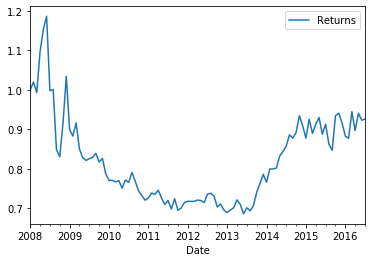

In [49]:
ftl.portfolio_return.plot()

### Follow the Regularized Leader

FTRL mediates the FTL strategy by adding a regularization term so that the portfolio doesn't change weights too drastically for each time period

In [50]:
ftrl = FTRL()
ftrl.allocate(stock_prices)

In [51]:
ftrl.all_weights


,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,...,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348,0.04348
2008-01-03,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2008-01-04,0.07719,0.01999,0.04997,0.05193,0.04168,0.04358,0.03115,0.06404,0.12154,0.09087,...,0.02680,0.04498,0.00128,0.05117,0.04730,0.03136,0.02703,0.03989,0.03936,0.03771
2008-01-07,0.00000,0.00000,0.13814,0.00000,0.00000,0.14982,0.00000,0.00000,0.02610,0.00000,...,0.16101,0.00000,0.00000,0.00000,0.00000,0.00000,0.10649,0.13336,0.13343,0.00000
2008-01-08,0.00000,0.00000,0.09715,0.00000,0.00000,0.12516,0.00000,0.00000,0.00000,0.00000,...,0.28485,0.00000,0.09596,0.00000,0.00000,0.00000,0.09896,0.09555,0.09898,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.38449,0.00000,0.00000,0.00000
2016-06-28,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00001,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.42872,0.00000,0.00001,0.00000
2016-06-29,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.41164,0.00000,0.00000,0.00001
